# DS Technical Challenge 


# Data wiki

Columns: 



*   **timestamp: int** - T=timestamp for the row. This is the time we got the auction from the exchange in the system.
*   **userid: str** - the user id we got as part of the auction data from the exchanges. the same user should have the same user id across different auctions. 
*   **publisher: str** - the app from which the auction is made. For example, if the user is currently reading news on “ynet” and is seeing a banner ad on the page of the news story, the publisher field will be “ynet”. Publishers are searchable in the app store in the following path (insert the publisher name where instead of the publisher_name parameter in the URL): https://play.google.com/store/apps/details?id=publisher_name&hl=en_US 
*   **publisher_category: str** - the category the publisher belongs to.
*   **countrycode: str** - the user's country (current location) as received in the auction data. 
*   **regioncode: str** - the user's region (current location) as received in the auction data. 
*   **cityname: str** - the users city (current location) as received in the auction data. 
*   **label: int** - the target. Values are the following: 
    *   **-1** = We didn’t win (someone else won and the user saw their ad banner) 
    *   **0** = We won, and the user didn’t install. 
    *   **1** = We won, and the user clicked and installed from our ad banner (Yay!) 

**Mind that by looking at all the rows for a given user (label = -1/0/1 all together) you will have the complete picture of the user's history.**

For example, this is how the complete history of user “example_user” would look in the data, sorted on timestamp.

![image info](https://drive.google.com/uc?id=1S98klbix810FJfkXj1vvUavF27h8n57Y)

1. We first saw the user on 2020-08-08 at 20:36:12.

2. We saw the user 4 times before we managed to win the auction and present them with an ad - we have 4 consecutive -1 labels.

3. On 2020-09-24 at 15:04:16 we managed to show the user an ad, but they didn’t install (label = 0).

4. On 2020-09-25 at 12:01:52 we managed to show the user an ad, and they installed the app (label = 1).

5. At the time of each auction below all the information from the previous auctions was available for us to use. 

Some examples:

1. By the second auction (index 1) we knew the user was seen in the publisher “com.rocketgames.bighitvegas” that is of the type “Slots”

2. By the third auction (index 2) we knew the user was seen in two different publishers from two different categories, “Slots” and “Quiz”.

3. By the third auction (index 2) we saw the user in two different locations - the city of Eufaula in AL (Alabama) and an unknown city in the state of GA (Georgia).

# The assignment - Read this carefully before you begin

I asked one of our engineers to query a data set for you. The properties of the data I asked him to query are: 

1. A total of **1000 users**.
2. All auctions from USA 
3. **All auctions won were presented with the same ad banner with the same ad creative for the same client**.
4. The file contains a lot of auctions in which we participated. 

**The aim of the exercise is to create a ML model that will take as input features that can be created from the data set and predict the probability of the user to install the app given that they were presented with the ad. in other words, calculate** <span style="text-decoration:underline;"> **P(label=1 | auction won).</span>**

At the beginning of every section of the assignment please write down a detailed plan of how you are going to approach that section step by step.

# Let's go!

### Imports

In [1]:
import pandas as pd
import numpy as np


### Load the data

Download the Data from [here](https://www.dropbox.com/s/kdkreplw1aro6z1/bigabid_ds_home_assignment.csv?dl=0)

In [2]:
df = pd.read_csv('bigabid_ds_home_assignment.csv')
df.timestamp = pd.to_datetime(df.timestamp)
df.head()

,timestamp,userid,publisher,publisher_category,countrycode,regioncode,cityname,label
0,2020-10-23 21:34:25,CAESEAKKo4tXCWvdcbw9iBzysmE,com.pixel.art.coloring.color.number,Color By Number,USA,FL,cape coral,-1
1,2020-09-05 22:18:04,CAESEAEuuuJYD9uc_YZ-essJrpI,com.fruitheroes.legend,Match 3,USA,GA,NaN,-1
2,2020-10-19 04:37:49,CAESEACn5u9Cao2If24GwLIU-J0,com.cardgame.solitaire,Solitaire,USA,AL,mobile,-1
3,2020-08-04 12:37:32,caeseavb--inqjr9lmfgylwg8k4,com.muji.sweet.candy.cookie,Match 3,USA,MI,detroit,-1
4,2020-09-04 19:48:12,CAESEAdXzd7naL4p1a0-0_gXSMs,com.surpax.ledflashlight.panel,NaN,USA,FL,inverness,-1


In [3]:
# i assume the engineer did take 1000 users and the userid is not case sensitive 
df.userid = df.userid.str.lower()
assert df.userid.nunique() == 1000

if 'countrycode' in df.columns: # enable re-run
    assert df.countrycode.unique() == ['USA']
    df.drop(columns=['countrycode'], inplace=True)

df.head()

,timestamp,userid,publisher,publisher_category,regioncode,cityname,label
0,2020-10-23 21:34:25,caeseakko4txcwvdcbw9ibzysme,com.pixel.art.coloring.color.number,Color By Number,FL,cape coral,-1
1,2020-09-05 22:18:04,caeseaeuuujyd9uc_yz-essjrpi,com.fruitheroes.legend,Match 3,GA,NaN,-1
2,2020-10-19 04:37:49,caeseacn5u9cao2if24gwliu-j0,com.cardgame.solitaire,Solitaire,AL,mobile,-1
3,2020-08-04 12:37:32,caeseavb--inqjr9lmfgylwg8k4,com.muji.sweet.candy.cookie,Match 3,MI,detroit,-1
4,2020-09-04 19:48:12,caeseadxzd7nal4p1a0-0_gxsms,com.surpax.ledflashlight.panel,NaN,FL,inverness,-1


Some Data Cleaning

In [4]:
# check if there is any missing value
df.isna().any(axis=0)

timestamp             False
userid                False
publisher             False
publisher_category     True
regioncode            False
cityname               True
label                 False
dtype: bool

In [5]:
# making sure the is one to one relationship publisher userid and publisher_category
assert (df.groupby("publisher")['publisher_category'].nunique() <= 1).all()
df.publisher_category.isna().sum()

83552

In [6]:
# tring to fill na with the unique value of the publisher
df.publisher_category = df.groupby("publisher")['publisher_category'].fillna(method='ffill')
df.publisher_category.isna().sum() # seems all the missing publisher_category are missing becuase the publisher is unknown.

83552

In [7]:
df.loc[df.publisher_category.isna(),:].publisher.unique()
assert (df.groupby("publisher_category")['publisher'].nunique() > 1).any()
# i don't see any simple way to fix this (we can try complex logic like clustering) and since the relashionship between publisher_category can help, 
# let's keep the columns and just create new 'publisher_category' 'unknown'
df.publisher_category.fillna('unknown', inplace=True)


In [8]:
df.cityname.isna().sum()
# since there are alot of missing cityname, and users move citys, we can fill it will the last known city

34362

In [9]:
df = df.sort_values(by=['userid', 'timestamp'])
df.cityname = df.groupby('userid')['cityname'].fillna(method='ffill')

df.cityname.isna().sum()


9304

In [10]:
# checking all the rest of missing cityname comes from users that never had a cityname in thier history
assert (df.loc[df.cityname.isna(),:].groupby('userid')['cityname'].nunique() == 0).all() 

# let's fill it with a tag 'unknown', depending on the way we will use the feature, we will convert 'unknown' to other value.
# for example, if every cityname will be represented as lat and lon, we will encode 'unknown' as central USA lat and lon.
df.cityname.fillna('unknown', inplace=True)

In [11]:
assert not df.isna().any().any(), "there are still missing values"

Some EDA

<AxesSubplot:>

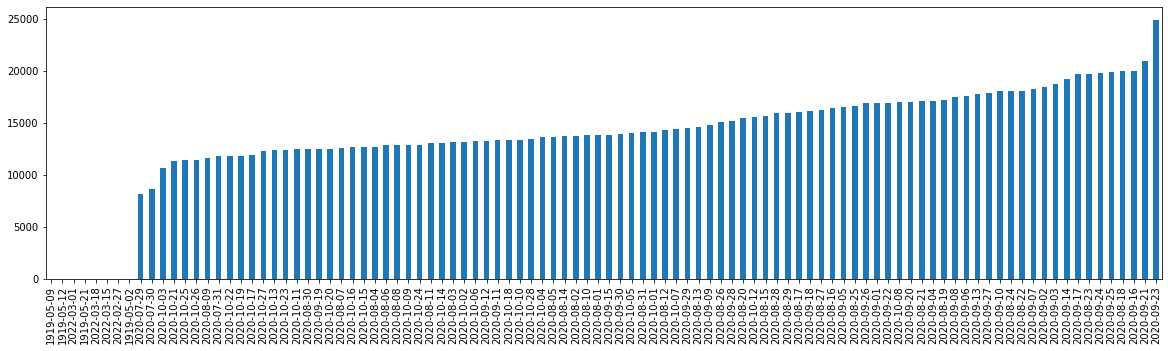

In [12]:
df['timestamp'].dt.date.value_counts().sort_values().plot(kind='bar',figsize=(20,5))
# look like the valid dates are only from 2020

In [13]:
# filter the rest
df = df[df.timestamp.dt.year == 2020]
df.head()

,timestamp,userid,publisher,publisher_category,regioncode,cityname,label
1008509,2020-08-02 00:20:20,caesea-2ak6qthizei5roxedof4,com.rocketgames.vivadeluxe,Slots,IL,summit,0
1188552,2020-08-02 00:20:32,caesea-2ak6qthizei5roxedof4,slots.grandwin.classic.vegas.casino.free,Slots,IL,summit,-1
941201,2020-08-04 02:38:54,caesea-2ak6qthizei5roxedof4,com.rocketgames.tripledouble,Slots,IL,summit,-1
468115,2020-08-04 02:39:20,caesea-2ak6qthizei5roxedof4,com.rocketgames.vivadeluxe,Slots,IL,summit,0
568806,2020-08-04 15:07:03,caesea-2ak6qthizei5roxedof4,slots.grandwin.classic.vegas.casino.free,Slots,IL,summit,-1


<AxesSubplot:title={'center':'Histogram of number of interactions per user'}, ylabel='Frequency'>

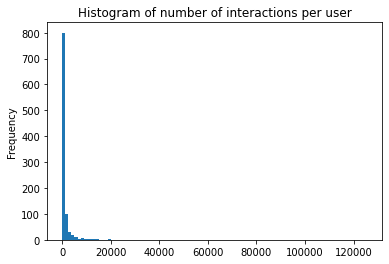

In [14]:
df.userid.value_counts().plot(kind='hist', bins=100, title='Histogram of number of interactions per user')

In [15]:
df.userid.value_counts().quantile(.05) 
# if we agree to not serve about 5% of users, we can build a time series model with history of 10 time steps.
# we will need to understand what we will be the action to requested with less the 10 time steps.

10.0

<AxesSubplot:>

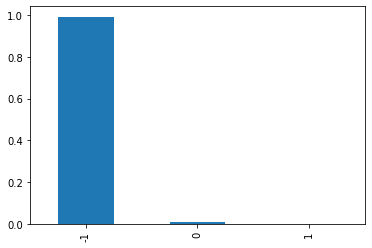

In [16]:
(df.label.value_counts() / df.shape[0]).plot(kind="bar")
# the data is skewed, we need to balance the data

<AxesSubplot:title={'center':'Percentage of won auction'}, ylabel='label'>

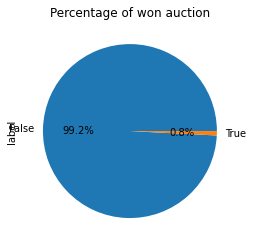

In [17]:
(df.label >= 0).value_counts().plot(kind="pie", autopct="%1.1f%%",title="Percentage of won auction")
# we overall didn't win alot of auction

In [18]:
# lets look at the top users in the system
temp = df.loc[df.label.isin([0,1]),:]
temp.userid.value_counts().sort_values().tail(10)
# look like there is a single user that is a spammer, let's remove him

caeseab4dvhr2bgcn-holy8zqya      32
caesebyzzkqabb3xxsurnm9rrei      32
caesee5mpsrqumcwzm0jmciuw10      34
caesecsp2sn6uqiifstq9vxopsg      41
caeseaf30q7pwgmagah_8qqfnyc      41
caeseaphy_bfvyjaroccunb2tgu      43
caeseancw-ofcqcegpyoaw7wn4u      44
caeseeqtzxmeukqyoo338_zh5us      47
caeseaqkgkb76pj-arzyooevhme      47
caesefnhbst2pzvq5avhtcbundq    5555
Name: userid, dtype: int64

In [19]:
not_noraml_user = ['caesefnhbst2pzvq5avhtcbundq'] # we would probably need to create different approch for spammers, they can offer alot of revenue.
df = df.loc[~df.userid.isin(not_noraml_user),:] 

In [20]:
temp = df.loc[df.label.isin([0,1]),:]
users_to_plot = temp.userid.value_counts().sort_values().tail(10).index

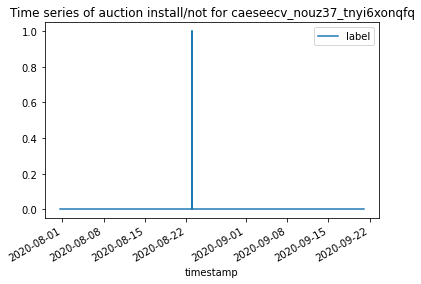

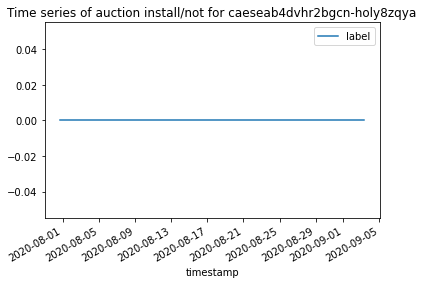

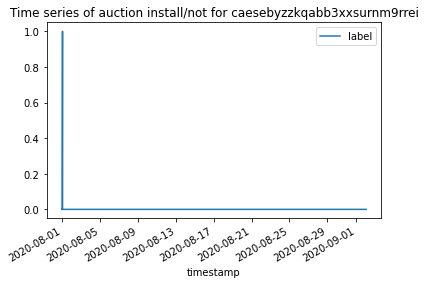

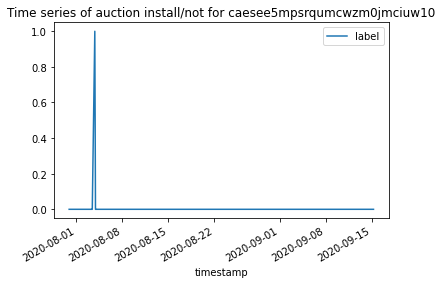

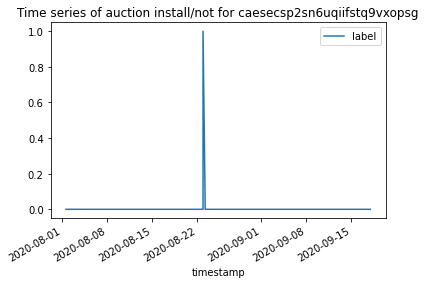

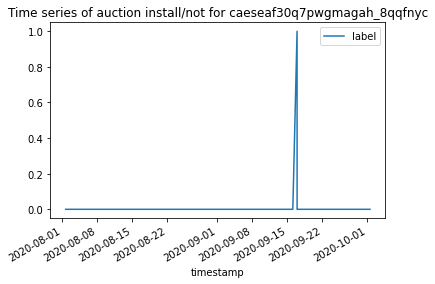

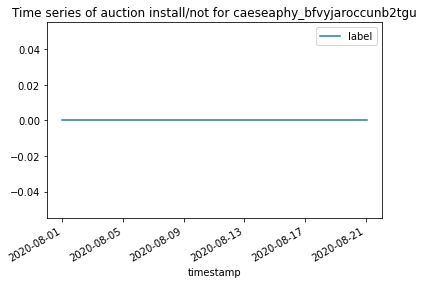

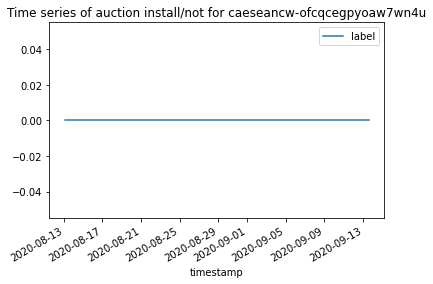

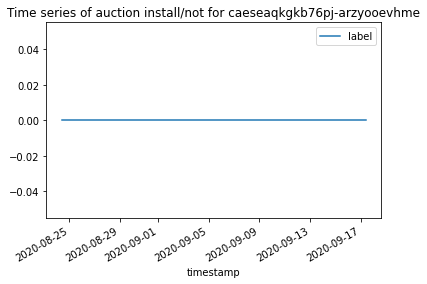

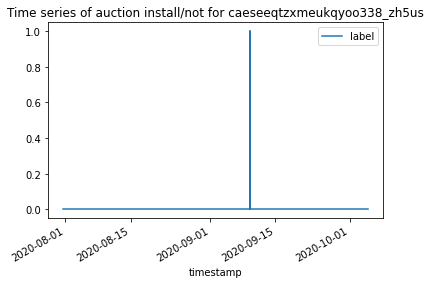

In [21]:
for user in users_to_plot:
    temp[temp.userid == user][['timestamp','label']].plot(kind='line', x='timestamp', y='label', title=f'Time series of auction install/not for {user}')
# looks like there is a single install event for the large users, and after the intalled event we are still offered with the auction.

<AxesSubplot:title={'center':'Distribution of install events per user'}>

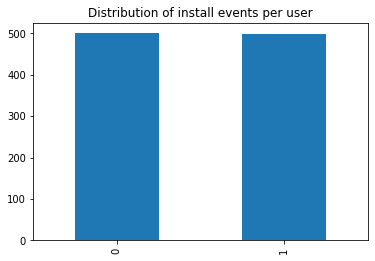

In [22]:
temp.groupby('userid')['label'].sum().value_counts().plot(kind='bar', title='Distribution of install events per user')
# looks like there is only a single install event at most for all users.
# OPSS! this was one of the ways the data was collected, but we learned the users didn't uninstalled the app.

<AxesSubplot:title={'center':'Distribution of install events per publisher_category'}, xlabel='publisher_category'>

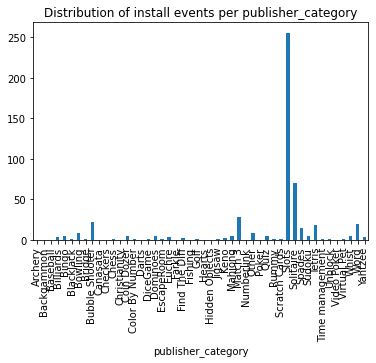

In [23]:
temp.groupby('publisher_category').label.sum().plot(kind='bar', title=f'Distribution of install events per publisher_category')

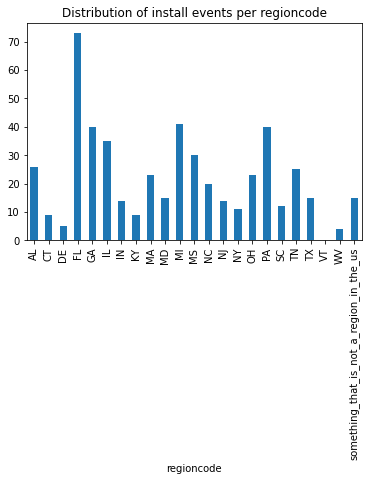

In [24]:
temp.groupby('regioncode').label.sum().plot(kind='bar', title=f'Distribution of install events per regioncode')
# assuming 'something_that_is_not_a_region_in_the_us' meaning that the value is a valid region but not in the US, and since we are focused on the US, we can remove it.
df = df.loc[~df.regioncode.isin(['something_that_is_not_a_region_in_the_us']),:]

<AxesSubplot:title={'center':'Distribution of install events per regioncode'}, xlabel='regioncode'>

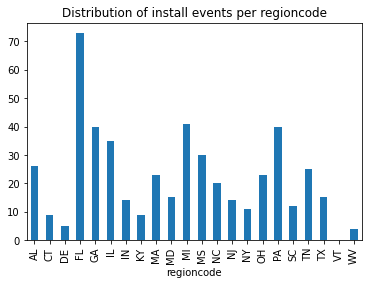

In [25]:
temp = df.loc[df.label.isin([0,1]),:]

temp.groupby('regioncode').label.sum().plot(kind='bar', title=f'Distribution of install events per regioncode')


<AxesSubplot:title={'center':'Largest events per publisher'}, xlabel='publisher'>

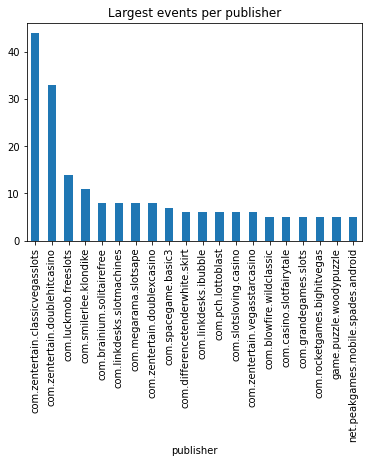

In [26]:
temp.groupby('publisher').label.sum().nlargest(20).plot(kind='bar', title=f'Largest events per publisher')


<AxesSubplot:title={'center':'Largest events per publisher'}, xlabel='publisher'>

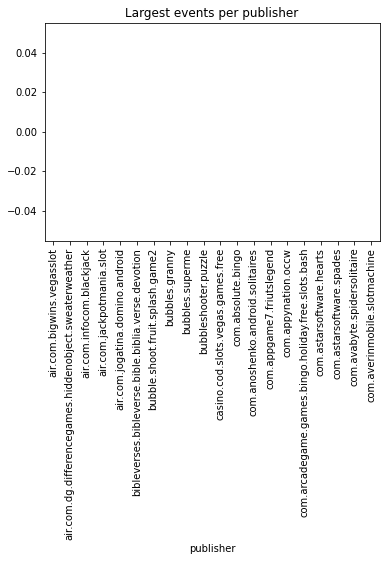

In [27]:
temp.groupby('publisher').label.sum().nsmallest(20).plot(kind='bar', title=f'Largest events per publisher')


PLAN:
We will first build a very simple model that will predict if the user will install the app only on the basis of the current auction, we will:
- use catagorial encoding to the "publisher","publisher_category" "regioncode" "cityname"
- address the unbalanced samples? probably not, since in nature this will be skewed to not installing.
- train a simple classification model.



We will add historical features base on the historical auctions of this user.

<AxesSubplot:title={'center':'Percentage of won auction'}, ylabel='label'>

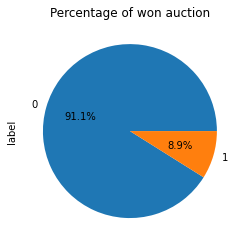

In [28]:

basic_samples = df[df.label.isin([0,1])].drop(columns=['userid'])
basic_samples.label.value_counts().plot(kind="pie", autopct="%1.1f%%",title="Percentage of won auction")

In [29]:
basic_samples.sort_values(by="timestamp", inplace=True) # prevent data leakage by sorting by timestamp
basic_samples.head()

,timestamp,publisher,publisher_category,regioncode,cityname,label
441894,2020-07-29 00:01:09,puzzle.games.bubble.shooter.deluxe,Bubble Shooter,OH,trotwood,0
665748,2020-07-29 00:04:23,com.spacegame.solitaire.basic,Solitaire,CT,hartford county,0
1345799,2020-07-29 00:10:10,com.ageofsolitaire.classicsolitaire,Solitaire,CT,lebanon,0
1232576,2020-07-29 00:28:30,com.sophia.zumba.game,Bubble Shooter,GA,tallapoosa,0
1082606,2020-07-29 01:00:09,com.rocketgames.throneofdragons,Slots,CT,wethersfield,0


In [30]:

test_start_index = int(basic_samples.shape[0] * 0.75)

train_data_samples,train_data_labels = basic_samples.iloc[:test_start_index].drop(columns=["label"]), basic_samples.iloc[:test_start_index].label
test_data_samples ,test_data_labels = basic_samples.iloc[test_start_index:].drop(columns=["label"]), basic_samples.iloc[test_start_index:].label

print("Training data size: ", train_data_samples.shape[0])
print("Test data size: ", test_data_samples.shape[0])

Training data size:  4068
Test data size:  1356


In [31]:
from catboost import CatBoostClassifier

categorical_features_indices = ["publisher","publisher_category","regioncode","cityname"]
model = CatBoostClassifier(iterations=10,
                           depth=3,
                           learning_rate=.1,
                           loss_function='Logloss',
                           verbose=True,auto_class_weights='Balanced')
model.fit(train_data_samples,train_data_labels,cat_features=categorical_features_indices)


0:	learn: 0.6912180	total: 52ms	remaining: 468ms
1:	learn: 0.6905133	total: 53.4ms	remaining: 213ms
2:	learn: 0.6889746	total: 54.4ms	remaining: 127ms
3:	learn: 0.6871373	total: 55.4ms	remaining: 83.1ms
4:	learn: 0.6865306	total: 56.4ms	remaining: 56.4ms
5:	learn: 0.6841761	total: 57.2ms	remaining: 38.1ms
6:	learn: 0.6820669	total: 58.1ms	remaining: 24.9ms
7:	learn: 0.6809335	total: 59ms	remaining: 14.7ms
8:	learn: 0.6788660	total: 59.8ms	remaining: 6.65ms
9:	learn: 0.6773123	total: 60.6ms	remaining: 0us


In [32]:
from sklearn.metrics import classification_report
predicted_test_data_labels = model.predict(test_data_samples)
print(classification_report(test_data_labels, predicted_test_data_labels, target_names=['not installed', 'installed']))
# To much false positives

               precision    recall  f1-score   support

not installed       0.91      0.37      0.53      1183
    installed       0.15      0.76      0.25       173

     accuracy                           0.42      1356
    macro avg       0.53      0.57      0.39      1356
 weighted avg       0.82      0.42      0.50      1356



In [33]:
model.predict_proba(test_data_samples) # << if we would like to see the probability of winning

array([[0.49117573, 0.50882427],
       [0.45927053, 0.54072947],
       [0.45927053, 0.54072947],
       ...,
       [0.43855901, 0.56144099],
       [0.43855901, 0.56144099],
       [0.45232466, 0.54767534]])

Improving the baseline:

    - DL is out of the question since we need more data then about 11K samples, otherwise i would have models it as time series classification.
    - classical classification. lets compute lag features, we assume the auction result return immediately which is not the case, so in reallife will need to model some cache, where the cache is updated once the auction result returned and it used to populate the features.
        Feature: 
        - is the user already installed the app.
        - number of historical won and not installed.
        - cityname convert to lat lon.
        - encode the 'publisher_category','publisher','regioncode' which contains importent information.
        - the time,season the app was installed in.

In [34]:
df.sort_values(by="timestamp", inplace=True) # prevent data leakage by sorting by timestamp
df.head()

,timestamp,userid,publisher,publisher_category,regioncode,cityname,label
450495,2020-07-29 00:00:05,caeseb4wih7tlwadfk5esvr7lu4,com.ageofsolitaire.classicsolitaire,Solitaire,CT,lebanon,-1
1149357,2020-07-29 00:00:11,caesea4dn9vpxvjjdtwppntunku,bubble.shoot.bubbles.game.saga.world,Bubble Shooter,FL,miami-dade county,-1
752391,2020-07-29 00:00:12,caesee6jlzi7jmnwasok5k543_o,com.ea.scrabblefree_na,Word,NC,charlotte,-1
431433,2020-07-29 00:00:12,caeseabx7nan1x3xxixwwfcaowi,com.crazystudio.mms6,unknown,FL,oviedo,-1
96478,2020-07-29 00:00:47,caesee6jlzi7jmnwasok5k543_o,com.ea.scrabblefree_na,Word,NC,charlotte,-1


In [45]:
from geopy.geocoders import Nominatim

def get_coordinates(cityname):
    geolocator = Nominatim(user_agent="myapplication")
    city = cityname
    country = "US"
    loc = geolocator.geocode(city+','+ country)
    if loc:
        return loc.latitude, loc.longitude
    print("Can't find coordinates for ", city)
    return 0,0

coordinates = dict()
for city in df["cityname"].unique():
    coordinates[city] = get_coordinates(city)


Can't find coordinates for  monitor charter township
Can't find coordinates for  new salem borough
Can't find coordinates for  greater carrollwood
Can't find coordinates for  white lake charter township


In [57]:
coordinates["monitor charter township"] = (43.6038248,-83.9824139)
coordinates["new salem borough"] = (39.9038276,-76.78763)
coordinates["greater carrollwood"] =  (28.0591123,-82.4943509)
coordinates["white lake charter township"] =  (42.6565737,-83.4688826)

In [59]:
df["latitude"],df["longitude"] = zip(*df["cityname"].apply(lambda x:coordinates[x]))

In [74]:
# number of auctions
df['num_of_auctions'] = df.groupby('userid').label.expanding().count().droplevel(axis=0,level=0)

In [75]:
# number of already installed apps
df['already_installed_app'] = df.label.map({-1:0,1:1,0:0})
df['already_installed_app'] = df.groupby('userid').already_installed_app.expanding(min_periods=0).sum().droplevel(axis=0,level=0)

In [76]:
# won and didn't installed apps
df['won_not_installed_app'] = df.label.map({-1:0,1:0,0:1})
df['won_not_installed_app'] = df.groupby('userid').won_not_installed_app.expanding(min_periods=0).sum().droplevel(axis=0,level=0)

In [77]:
categorical_features_indices = ["publisher", "publisher_category","regioncode","cityname"]

for cat in categorical_features_indices:

    won_column_name = f'won_all_time_by_cat_{cat}'
    df[won_column_name] = df.label.map({-1:0,0:0,1:1})
    df[won_column_name] = df.groupby(cat)[won_column_name].expanding(min_periods=0).mean().droplevel(axis=0,level=0)

In [78]:
df['timestamp_hour'] = df.timestamp.dt.hour
df['timestamp_minutes'] = df.timestamp.dt.minute
df['timestamp_day'] = df.timestamp.dt.day
df['timestamp_month'] = df.timestamp.dt.month
df['timestamp_day_of_week'] = df.timestamp.dt.day_of_week

In [79]:
second_df = df[df.label.isin([0,1])].drop(columns=['timestamp','userid'])
train_data_samples,train_data_labels = second_df.iloc[:test_start_index].drop(columns=["label"]), second_df.iloc[:test_start_index].label
test_data_samples ,test_data_labels = second_df.iloc[test_start_index:].drop(columns=["label"]), second_df.iloc[test_start_index:].label

In [80]:
from catboost import CatBoostClassifier

categorical_features_indices = ["publisher","publisher_category","regioncode","cityname"]
model = CatBoostClassifier(iterations=10,
                           depth=3,
                           learning_rate=.1,
                           loss_function='Logloss',
                           verbose=True,auto_class_weights='Balanced')
model.fit(train_data_samples,train_data_labels,cat_features=categorical_features_indices)

0:	learn: 0.6317964	total: 1.67ms	remaining: 15ms
1:	learn: 0.5812912	total: 3.08ms	remaining: 12.3ms
2:	learn: 0.5382610	total: 4.22ms	remaining: 9.85ms
3:	learn: 0.5028151	total: 5.19ms	remaining: 7.78ms
4:	learn: 0.4730827	total: 6.26ms	remaining: 6.26ms
5:	learn: 0.4473441	total: 7.73ms	remaining: 5.16ms
6:	learn: 0.4257669	total: 19.9ms	remaining: 8.53ms
7:	learn: 0.4054359	total: 22.2ms	remaining: 5.56ms
8:	learn: 0.3848800	total: 24.9ms	remaining: 2.76ms
9:	learn: 0.3710216	total: 28.6ms	remaining: 0us


In [81]:
predicted_test_data_labels = model.predict(test_data_samples)
print(classification_report(test_data_labels, predicted_test_data_labels, target_names=['not installed', 'installed']))

               precision    recall  f1-score   support

not installed       1.00      0.65      0.79      1183
    installed       0.29      1.00      0.45       173

     accuracy                           0.69      1356
    macro avg       0.65      0.82      0.62      1356
 weighted avg       0.91      0.69      0.74      1356

